In [1]:
#usual stuff
import numpy as np
from astropy.io import fits
location_of_files = '/home/secco/project2-kicp-secco/delve/PSF_FILES/'

In [2]:
#stuff needed to load PSF files and measure shapes 
import galsim
from galsim.des import DES_PSFEx
import ngmix
from ngmix.fitting import Fitter as LMSimple
from ngmix.admom import AdmomFitter as Admom

In [3]:
#loading CCD image and starlist and psf model for a given CCD and expnum
im = fits.open(location_of_files+"D00145430_z_c01_r4148p01_immasked.fits.fz")
starlist = fits.open(location_of_files+"D00145430_z_c01_r4148p01_psfex-starlist.fits")
des_psfex = galsim.des.DES_PSFEx(location_of_files+'D00145430_z_c01_r4148p01_psfexcat.psf')

#get the pixel location of the first star that passes flagging:
goodstars= np.where(starlist[2].data['flags_psf']==0)[0] #flags for good stars
Y = starlist[2].data['x_image'].astype(int)[goodstars[0]] #note that I'm exchanging X and Y here!!!
X = starlist[2].data['y_image'].astype(int)[goodstars[0]]
Y_float = starlist[2].data['x_image'][goodstars[0]] #getting them as floats also (as in the file itself)
X_float = starlist[2].data['y_image'][goodstars[0]]

print(X,Y)

73 1664


In [4]:
#now get the image and weight cutouts for that stars, for a box of a given size
box=11 #
image_cutout = im['sci'].data[ X-box:X+box , Y-box:Y+box ]
weight_cutout = im['wgt'].data[ X-box:X+box , Y-box:Y+box ]
#there's another extension in the immasked file called 'MSK' which stands for mask, 
#not sure how to use it but loading it below
mask_cutout = im['msk'].data[ X-box:X+box , Y-box:Y+box ]

#also create the PSF model image:
psf_pos= galsim.PositionD(X_float, Y_float)
psf_model = des_psfex.getPSF(psf_pos)
psf_image = psf_model.drawImage(scale=0.699999) 
psf_image_array = psf_image.array

<IPython.core.display.Javascript object>


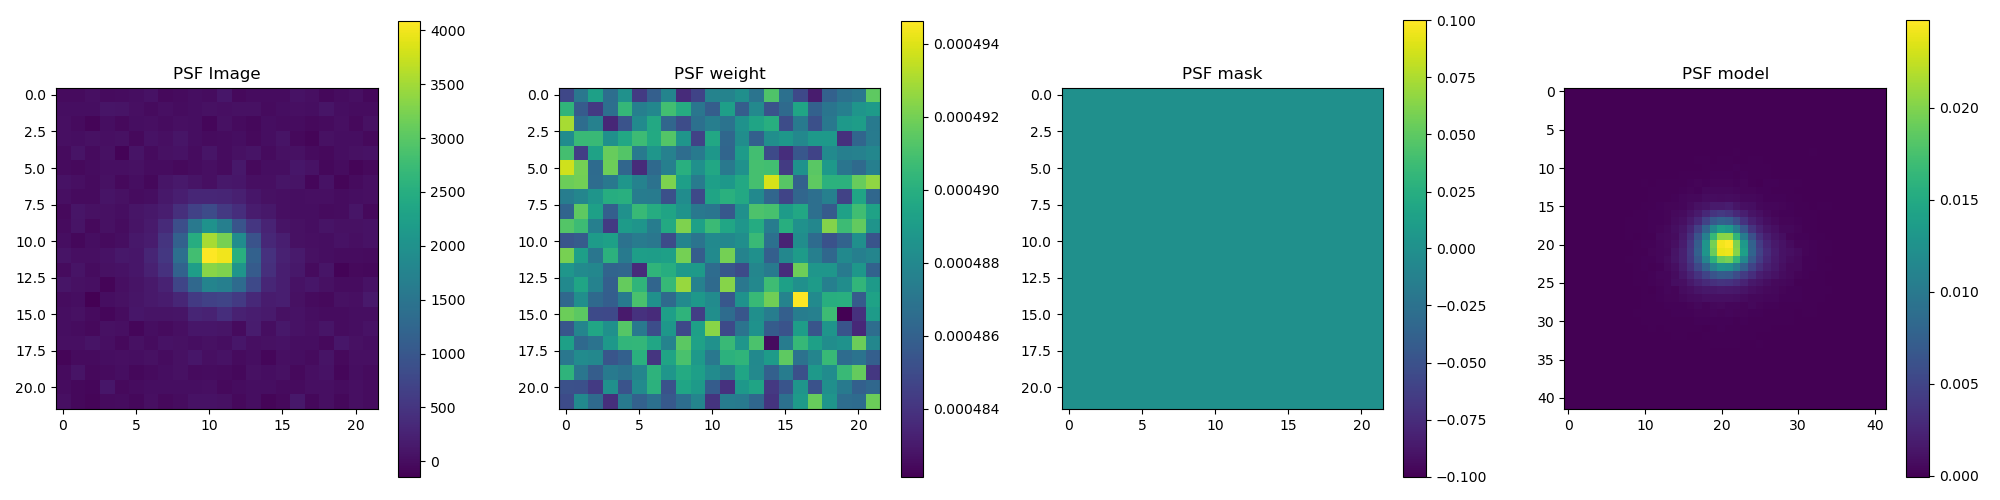

In [5]:
#this is what each of these arrays look like:
%matplotlib notebook
import matplotlib.pyplot as pl

pl.figure(figsize=(20,5))
pl.subplot(141)
pl.title('PSF Image')
pl.imshow(image_cutout)
pl.colorbar()
pl.subplot(142)
pl.title('PSF weight')
pl.imshow(weight_cutout)
pl.colorbar()
pl.subplot(143)
pl.title('PSF mask')
pl.imshow(mask_cutout)
pl.colorbar()
pl.subplot(144)
pl.title('PSF model')
pl.imshow(psf_image_array)
pl.colorbar()
pl.tight_layout()
pl.show()

In [6]:
#now create an NGMix object which we will measure the shapes over
obs = ngmix.Observation(
    image=image_cutout,
    weight=weight_cutout,
    jacobian=ngmix.jacobian.DiagonalJacobian(
    x=box, y=box, scale=0.263)) #x and y are the center of the jacobian, assuming for now a diagonal jacobian

#measure shape
rng = np.random.RandomState(seed=42)
try:
    am = Admom(rng=rng)
    res = am.go(obs, 0.3)
    if res['flags'] != 0:
        print('image got flagged(?)')

    lm = LMSimple('turb')
    lm_res = lm.go(obs, res['pars'])
    if lm_res['flags'] == 0:
        _g1 = lm_res['pars'][2]
        _g2 = lm_res['pars'][3]
        _T = lm_res['pars'][4]
except ngmix.gexceptions.GMixRangeError:
    print('NGmix error')
else:
    print('Got g1=%1.4f, g2=%1.4f, T=%1.4f'%(_g1,_g2,_T))


Got g1=0.0074, g2=0.0454, T=0.5143


In [11]:
#now do the same for psf model
obs = ngmix.Observation(
    image=psf_image_array,
    weight=np.ones(psf_image_array.shape)/1e10,
    jacobian=ngmix.jacobian.DiagonalJacobian(
    x=int(psf_image_array.shape[0]/2), y=psf_image_array.shape[1]/2, scale=0.699999)) #x and y are the center of the jacobian, assuming for now a diagonal jacobian

#measure shape
rng = np.random.RandomState(seed=42)
try:
    am = Admom(rng=rng)
    res = am.go(obs, 0.3)
    if res['flags'] != 0:
        print('image got flagged(?)')
        print(res['flags'])

    lm = LMSimple('turb')
    lm_res = lm.go(obs, res['pars'])
    if lm_res['flags'] == 0:
        _g1 = lm_res['pars'][2]
        _g2 = lm_res['pars'][3]
        _T = lm_res['pars'][4]
except ngmix.gexceptions.GMixRangeError:
    print('NGmix error')
else:
    print('Got g1=%1.4f, g2=%1.4f, T=%1.4f'%(_g1,_g2,_T))

Got g1=0.0192, g2=0.0115, T=7.3054
